In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import rqfactor
import talib
from rqalpha.apis import *
from rqfactor.notebook.exposure import factor_analysis
from rqoptimizer import *
from rqoptimizer.utils import *
from rqdatac import *
from rqalpha_plus import run_func
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from functools import wraps
warnings.filterwarnings("ignore")
rqdatac.init()

Cannot initialize filter sz3: File not found


In [7]:
df_etf = pd.read_excel('../../ETF0-ML/etf标的.xlsx')
etf_code = df_etf.code.values.tolist()
etf_code = [str(code) for code in etf_code]
df_etf = all_instruments(type='ETF' , market = 'cn')
df_etf = df_etf[df_etf.trading_code.isin(etf_code)]

In [8]:
symbol = df_etf.order_book_id.values.tolist()
start = "2020-01-01"
end = "2023-12-31"
frequency = "1d"

In [9]:
df_price_entry = get_price(symbol, start, end, frequency)[['close']].unstack(level = 0)
df_price_entry.columns = df_price_entry.columns.droplevel(0)
frequency_h = '60m'
df_price_exit = get_price(symbol, start, end, frequency_h)[['close']].unstack(level = 0)
df_price_exit.columns = df_price_exit.columns.droplevel(0)

<Axes: xlabel='date'>

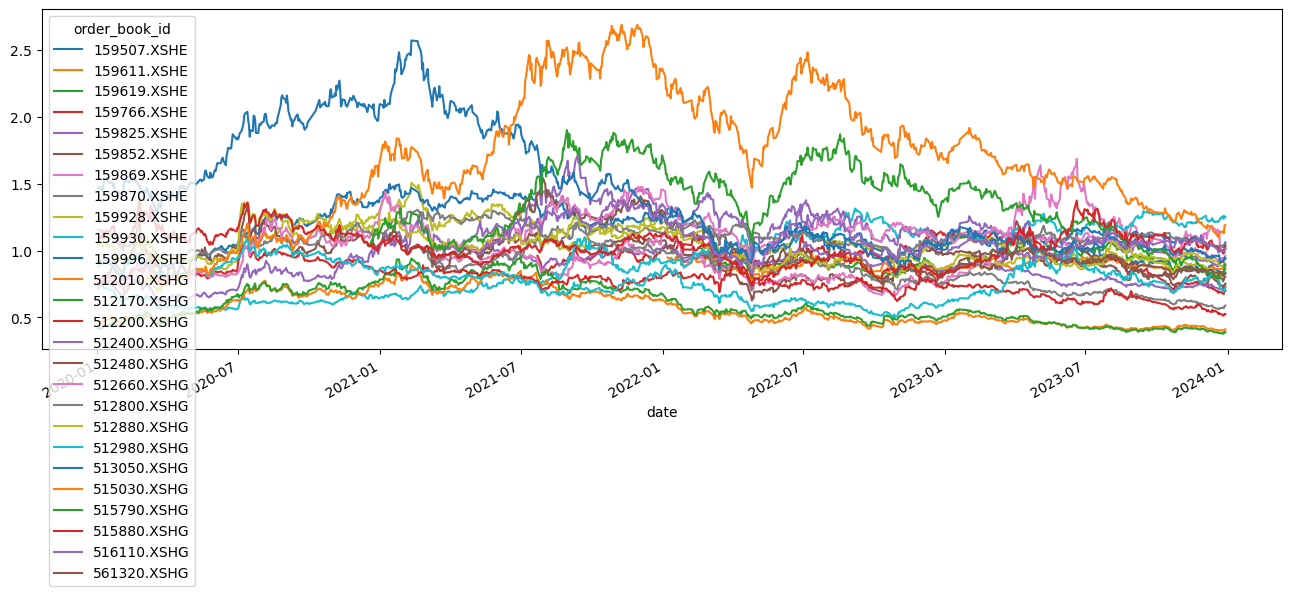

In [10]:
df_price_entry.plot(figsize = (16,5))

#### 截面收益

{}
{}
{}
{}
{}
{}
-0.0009170856507230438
-0.003289210233592916
0.0009577308120133365
0.0030428698553948753
-0.003161067853170207
2.4471635150103045e-06
0.012893882091212448
0.0023343715239154414
-0.004210901001112374
-0.0017332591768632023
0.0013501668520578092
0.0011715239154615864
0.002820467185761932
{'159928.XSHE': 0.0007148907713787354, '159930.XSHE': -0.003875459493686533, '512200.XSHG': -0.0022928528090428234, '512800.XSHG': -0.002941459052849601, '512880.XSHG': 0.0010594994240012518}
2020-02-24 00:00:00: 买入 159930.XSHE, 价格 0.66, 数量 7500
2020-02-24 00:00:00: 买入 512800.XSHG, 价格 1.05, 数量 4800
2020-02-28 10:30:00: 卖出 159930.XSHE, 价格 0.629, 数量 7500
-0.00014020022246941913
-0.0022909899888765507
0.0003770189098998856
0.0028890767519465926
-0.001297886540600698
0.0007601779755283408
0.0117497219132369
0.0037842046718576036
-0.0030774193548387245
0.0010002224694104522
0.001890545050055606
-0.0012743047830923746
0.0062551724137930725
{'159928.XSHE': -0.0009934395134647595, '159930.XSHE'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-0.002347719688542846
-0.005908565072302573
-0.005825361512792017
-0.0012700778642936944
-0.0013314794215795447
-0.00017864293659622756
{'159507.XSHE': -0.0008780584256722193, '159619.XSHE': -0.0023135317478647, '159766.XSHE': -0.002807429599989839, '159852.XSHE': -0.0008907570843853748, '159870.XSHE': -0.0035998024655808083, '159928.XSHE': -0.003346959161869066, '159996.XSHE': -0.0019442383016942007, '512010.XSHG': -0.002793576195176307, '512170.XSHG': -0.002829470222116257, '512200.XSHG': -0.0020467528282582916, '512400.XSHG': -0.0024621922903120476, '512480.XSHG': -0.003224253999909742, '512660.XSHG': -0.001591894939385504, '512800.XSHG': -0.001808325958329984, '512880.XSHG': -0.002396315504947279, '513050.XSHG': -0.0016911275508907785, '515030.XSHG': -0.005037439484563374, '515790.XSHG': -0.005695166334271202, '515880.XSHG': -0.0010066731677697005, '516110.XSHG': -0.0020174041801294656, '561320.XSHG': -0.0005558010790031885}
2023-12-18 00:00:00: 买入 515790.XSHG, 价格 0.791, 数量 9200
20

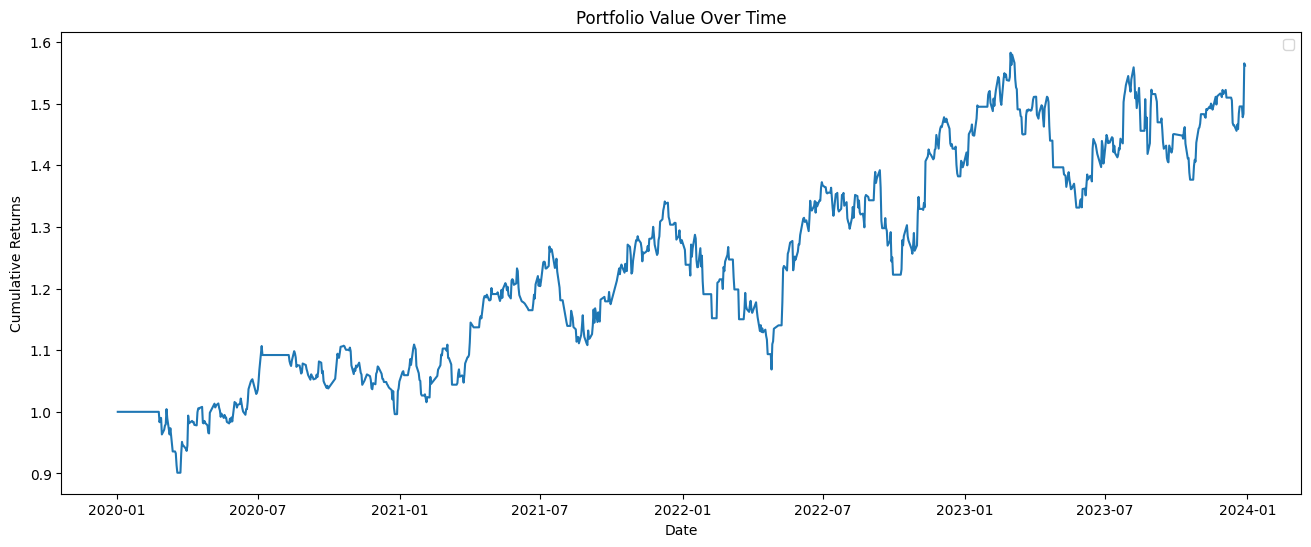

初始资金: 10000
最终资金: 15616.599999999991
年化收益率: 12.17%
最大回撤: -20.32%
未考虑无风险利率的夏普比率: 0.63
交易次数: 285


In [22]:
initial_capital = 10000
positions = 2
slippage_and_fees = 0.00
portfolio_value_tracker = []

capital = initial_capital
cash = initial_capital
etf_value = 0
holdings = {}
peak = {}
stop_loss_point = {}
take_profit_point = {}
entry_price = {}

def calculate_slope(price_data):
    price_data = price_data.replace([np.inf, -np.inf], np.nan).dropna()
    if len(price_data) < 2:
        return np.nan
    return np.polyfit(range(len(price_data)), price_data, 1)[0]

def check_buy_signals(df, date):
    etf_average_returns = {}
    etf_slopes = {}
    for etf in df.columns:
        price_data = df[etf].loc[:date].iloc[-30:]
        if price_data.count() < 30:
            continue
        daily_returns = price_data.pct_change().dropna() 
        average_return = daily_returns.mean() 
        slope = calculate_slope(price_data)
        etf_average_returns[etf] = average_return
        etf_slopes[etf] = slope
        print(slope)

    etfs_with_positive_slope = {etf: avg_ret for etf, avg_ret in etf_average_returns.items() if etf_slopes[etf] < 0}
    selected_etfs = sorted(etfs_with_positive_slope, key=etfs_with_positive_slope.get)[:2]
    print(etfs_with_positive_slope)
    return selected_etfs


def buy(etf, price, date):
    global capital, cash, etf_value, holdings, count
    if not np.isnan(price) and holdings.get(etf, 0) == 0:
        num_held_etfs = sum(1 for h in holdings.values() if h > 0)
        if num_held_etfs < positions:
            investable_cash = cash / (positions - num_held_etfs)
            etf_amount = int(investable_cash * (1 - slippage_and_fees) / price) // 100 * 100
            holdings[etf] = etf_amount
            cash -= etf_amount * price 
            entry_price[etf] = price 
            stop_loss_point[etf] = price * 0.97
            take_profit_point[etf] = price * 1.06
        
            print(f"{date}: 买入 {etf}, 价格 {price}, 数量 {etf_amount}")
            count += 1

def check_stop_conditions(etf, price):
    if holdings.get(etf, 0) <= 0:
        return False
    if price < stop_loss_point.get(etf, 0):
        return True
    if price >= take_profit_point.get(etf, 0):
        stop_loss_point[etf] = take_profit_point[etf]
        take_profit_point[etf] = entry_price[etf] * (1 + 0.01 * (int((price / entry_price[etf] - 1) / 0.01) + 1))
    return False

def sell(etf, price, date):
    global capital, cash, etf_value, holdings, count
    if not np.isnan(price) and holdings.get(etf, 0) > 0:
        proceeds = holdings[etf] * price * (1 - slippage_and_fees)
        cash += proceeds 
        etf_value -= holdings[etf] * price
        print(f"{date}: 卖出 {etf}, 价格 {price}, 数量 {holdings[etf]}")
        holdings[etf] = 0
        count += 1

start_date = pd.to_datetime('2019-01-02')
last_rebalance_date = start_date
trading_hours = ['10:30', '11:30', '14:00', '15:00']
count = 0

for date, prices_daily in df_price_entry.iterrows():
    date_str = date.strftime('%Y-%m-%d')
    if date.weekday() == 0 and date > last_rebalance_date:
        selected_etfs = check_buy_signals(df_price_entry, date)
        for etf in selected_etfs:
            if etf in prices_daily and not np.isnan(prices_daily[etf]):
                buy(etf, prices_daily[etf], date)
        last_buy_date = date  # 更新上次买入日期
    for trading_hour in trading_hours:
        datetime_str = f"{date_str} {trading_hour}"
        datetime_index = pd.to_datetime(datetime_str)
        if datetime_index in df_price_exit.index:
            prices_hourly = df_price_exit.loc[datetime_index]
            for etf in holdings.keys():  # 遍历当前持有的ETF
                if etf in prices_hourly and not np.isnan(prices_hourly[etf]):
                    price_hourly = prices_hourly[etf]
                    if check_stop_conditions(etf, price_hourly):
                        sell(etf, price_hourly, datetime_index)
    
    etf_value = sum(holdings.get(etf, 0) * prices_daily.get(etf, 0) for etf in holdings if holdings.get(etf, 0) > 0)
    capital = cash + etf_value
    portfolio_value_tracker.append(capital)

portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
annualized_dev = np.std(returns) * np.sqrt(252)
sharp_ratio = annualized_return / annualized_dev

plt.figure(figsize=(16, 6))
plt.plot(df_price_entry.index, portfolio_values/10000)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"未考虑无风险利率的夏普比率: {sharp_ratio:.2f}")
print(f"交易次数: {count}")

In [24]:
data = pd.DataFrame(df_price_entry.index, portfolio_values/10000)
data.to_csv('2.csv')